## **Table 1. Relevant dependencies for this Chapter**

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from statsmodels.stats.diagnostic import linear_lm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## **Table 2. Consumer Price Index (CPI) for All Urban Consumers (2000-2025)**


In [ ]:
start_date = '1990-01-01'
end_date = '2025-1-01'
inflation_data = DataReader('CPIAUCSL', 'fred', start_date, end_date)
usrec = DataReader('USREC', 'fred', start_date, end_date)

In [ ]:
print(usrec.head(25))

            USREC
DATE             
1990-01-01      0
1990-02-01      0
1990-03-01      0
1990-04-01      0
1990-05-01      0
1990-06-01      0
1990-07-01      0
1990-08-01      1
1990-09-01      1
1990-10-01      1
1990-11-01      1
1990-12-01      1
1991-01-01      1
1991-02-01      1
1991-03-01      1
1991-04-01      0
1991-05-01      0
1991-06-01      0
1991-07-01      0
1991-08-01      0
1991-09-01      0
1991-10-01      0
1991-11-01      0
1991-12-01      0
1992-01-01      0


In [ ]:
print(inflation_data)

            CPIAUCSL
DATE                
1990-01-01   127.500
1990-02-01   128.000
1990-03-01   128.600
1990-04-01   128.900
1990-05-01   129.100
...              ...
2024-08-01   314.121
2024-09-01   314.686
2024-10-01   315.454
2024-11-01   316.441
2024-12-01   317.685

[420 rows x 1 columns]


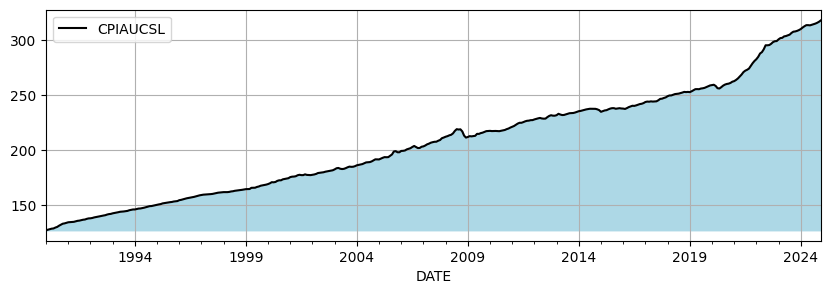

In [ ]:
inflation_data.plot(color = 'k', figsize = (10, 3))
plt.grid()
plt.fill_between(inflation_data.index, inflation_data['CPIAUCSL'], inflation_data['CPIAUCSL'].min(), color='lightblue')
plt.show()

## **Table 3. Markov Auto Regression Model**

In [ ]:
inflation_data['Inflation'] = np.log(inflation_data['CPIAUCSL']).diff(periods = 12) * 100
inflation_data = inflation_data.resample('MS').last()

model = sm.tsa.MarkovAutoregression(inflation_data['Inflation'].dropna(),
                                           k_regimes = 2,
                                           order = 2,
                                           switching_ar = False)

results = model.fit(method = 'bfgs',
                    maxiter = 1000)
print(results.summary())

                         Markov Switching Model Results                         
Dep. Variable:                Inflation   No. Observations:                  406
Model:             MarkovAutoregression   Log Likelihood                -152.406
Date:                  Fri, 24 Jan 2025   AIC                            318.812
Time:                          04:10:44   BIC                            346.856
Sample:                      01-01-1991   HQIC                           329.911
                           - 12-01-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5144      0.347      7.256      0.000       1.835       3.194
                             Regime 

This warning indicates that the model had to use numerical methods to approximate the covariance matrix because it couldn't be calculated directly. This can sometimes lead to less accurate estimates of the standard errors.

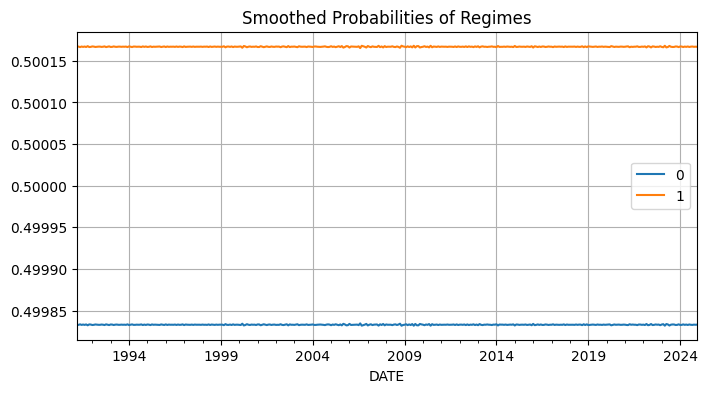

In [ ]:
smoothed_probs = results.smoothed_marginal_probabilities
smoothed_probs.plot(title='Smoothed Probabilities of Regimes', figsize=(8,4))
plt.grid()
plt.show()

[2.04192085 2.04328527]


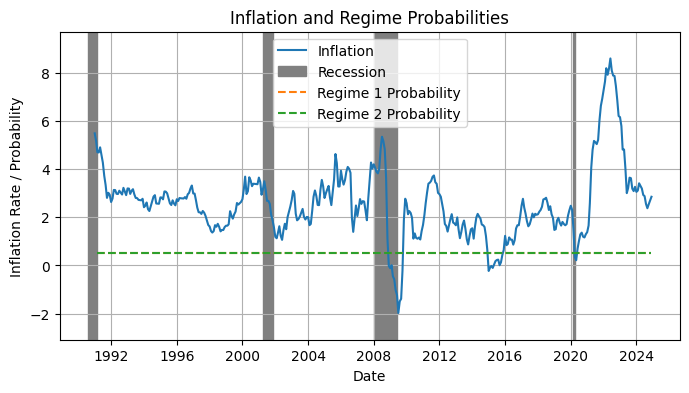

In [ ]:
print(results.expected_durations)

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(inflation_data.index, inflation_data['Inflation'], label = 'Inflation')
ax.fill_between(usrec.index, 0, 1,
                where = usrec['USREC'] == 1,
                color = 'gray',
                transform = ax.get_xaxis_transform(),
                label='Recession')
ax.plot(smoothed_probs.index, smoothed_probs[0], label='Regime 1 Probability', linestyle = '--')
ax.plot(smoothed_probs.index, smoothed_probs[1], label='Regime 2 Probability', linestyle = '--')
ax.set_xlabel('Date')
ax.set_ylabel('Inflation Rate / Probability')
ax.legend(loc = 'upper center')
plt.title('Inflation and Regime Probabilities')
plt.grid()
plt.show()

## **Table 4. Economic variables**

In [ ]:
start_date = '1990-01-01'
end_date = '2025-1-01'

fed_funds = DataReader('FEDFUNDS', 'fred', start_date, end_date)
gdp_growth = DataReader('A191RL1Q225SBEA', 'fred', start_date, end_date)
inflation_data = DataReader('CPIAUCSL', 'fred', start_date, end_date)
unemployment = DataReader('UNRATE', 'fred', start_date, end_date)

fed_funds = fed_funds.resample('MS').last()
gdp_growth = gdp_growth.resample('MS').last()
inflation_data = inflation_data.resample('MS').last()
unemployment = unemployment.resample('MS').last()

inflation_data['Inflation'] = np.log(inflation_data['CPIAUCSL']).diff(periods = 12) * 100

economic_data = pd.DataFrame({
    'FedFunds': fed_funds['FEDFUNDS'],
    'GDPGrowth': gdp_growth['A191RL1Q225SBEA'],
    'Inflation': inflation_data['Inflation'],
    'Unemployment': unemployment['UNRATE']})

economic_data = economic_data.dropna()
print(economic_data.head())

            FedFunds  GDPGrowth  Inflation  Unemployment
DATE                                                    
1991-01-01      6.91       -1.9   5.493372           6.4
1991-04-01      5.91        3.2   4.697834           6.7
1991-07-01      5.82        2.0   4.275117           6.8
1991-10-01      5.21        1.4   2.808758           7.0
1992-01-01      4.03        4.9   2.637516           7.3


In [ ]:
economic_data.replace([np.inf, -np.inf], np.nan, inplace=True)
economic_data.dropna(inplace=True)
economic_data.shape

(135, 4)

## **Table 5. ACF and PACF plots to select order**

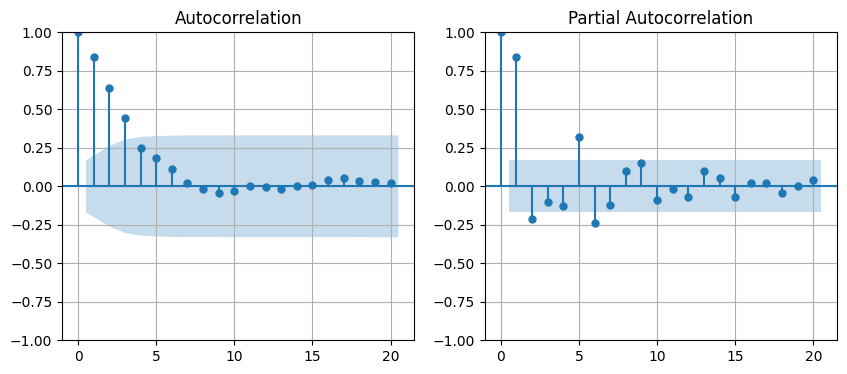

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
plot_acf(economic_data['Inflation'], lags = 20, ax = ax1)
ax1.grid()
plot_pacf(economic_data['Inflation'], lags = 20, ax = ax2)
ax2.grid()
plt.show()

## **Table 6. Parameters (regime, order) tuning and best model fit**

In [ ]:
best_aic = np.inf
best_model = None
best_k_regimes = None
best_order = None

for k_regimes in range(2, 5):
    for order in range(1, 5):
        model = sm.tsa.MarkovAutoregression(
            economic_data['Inflation'].dropna(),
            k_regimes = k_regimes,
            order = order,
            switching_ar = False,
            exog = economic_data[['FedFunds', 'GDPGrowth', 'Unemployment']].dropna())
        results = model.fit(method = 'lbfgs', maxiter = 10000, disp = False)

        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
            best_k_regimes = k_regimes
            best_order = order

print("Best AIC:", best_aic)
print("Best K Regimes:", best_k_regimes)
print("Best Order:", best_order)
print(best_model.summary())

Best AIC: 291.61652198194037
Best K Regimes: 2
Best Order: 2
                         Markov Switching Model Results                         
Dep. Variable:                Inflation   No. Observations:                  133
Model:             MarkovAutoregression   Log Likelihood                -135.808
Date:                  Fri, 17 Jan 2025   AIC                            291.617
Time:                          06:04:47   BIC                            320.520
Sample:                      01-01-1991   HQIC                           303.362
                           - 07-01-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3995      0.672      6.549      0.000

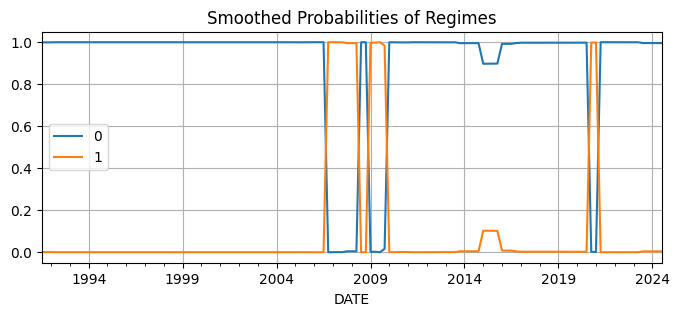

In [ ]:
smoothed_probs = best_model.smoothed_marginal_probabilities
smoothed_probs.plot(title='Smoothed Probabilities of Regimes', figsize=(8,3))
plt.grid()
plt.show()

[39.81444593  4.24505319]


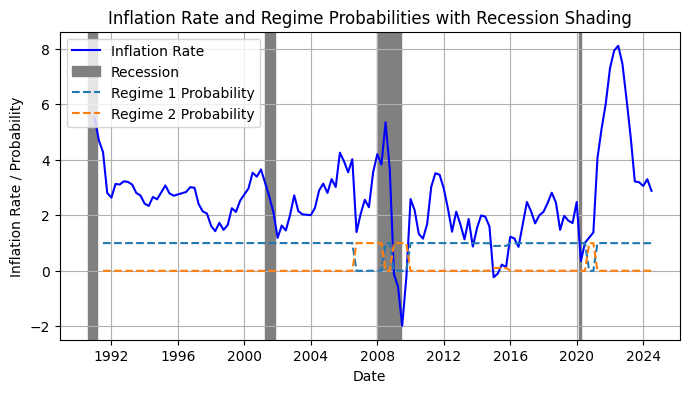

In [ ]:
expected_durations = best_model.expected_durations

print(expected_durations)

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(economic_data.index,
        economic_data['Inflation'],
        label = 'Inflation Rate',
        color = 'blue')

ax.fill_between(
    usrec.index,
    economic_data['Inflation'].min(),
    economic_data['Inflation'].max(),
    where = usrec['USREC'] == 1,
    color = 'gray',
    transform =ax.get_xaxis_transform(),
    label = 'Recession')


for i in range(best_model.k_regimes):
    ax.plot(
        smoothed_probs.index,
        smoothed_probs[i],
        label = f'Regime {i + 1} Probability',
        linestyle = '--')

ax.legend(loc='upper left')
ax.set_title('Inflation Rate and Regime Probabilities with Recession Shading')
ax.set_xlabel('Date')
ax.set_ylabel('Inflation Rate / Probability')
ax.grid(True)
plt.show()

## **Table 7. Ingest relevant dataset and perform necessary data processing**

In [ ]:
start_date = '1990-01-01'
end_date = '2025-01-01'
gdp_data = DataReader('GDPC1', 'fred', start_date, end_date)
unemployment = DataReader('UNRATE', 'fred', start_date, end_date)
inflation = DataReader('CPIAUCSL', 'fred', start_date, end_date)
interest_rate = DataReader('GS10', 'fred', start_date, end_date)
recession = DataReader('USREC', 'fred', start_date, end_date)

gdp_data = gdp_data.resample('QS').last()
gdp_data['GrowthRate'] = gdp_data['GDPC1'].pct_change() * 100
gdp_data.dropna(inplace=True)
unemployment = unemployment.resample('QS').last()
inflation = inflation.resample('QS').last()
interest_rate = interest_rate.resample('QS').last()
recession = recession.resample('QS').last()

data = pd.merge(gdp_data[['GrowthRate']], unemployment, left_index=True, right_index=True)
data = pd.merge(data, inflation, left_index=True, right_index=True)
data = pd.merge(data, interest_rate, left_index=True, right_index=True)
data = pd.merge(data, recession, left_index=True, right_index=True)
data.rename(columns={'GS10': 'InterestRate', 'CPIAUCSL': 'Inflation', 'UNRATE': 'Unemployment'}, inplace=True)

data['LaggedGrowthRate'] = data['GrowthRate'].shift(1)
data['LaggedUnemployment'] = data['Unemployment'].shift(1)
data['LaggedInflation'] = data['Inflation'].shift(1)
data['LaggedInterestRate'] = data['InterestRate'].shift(1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
print(data.tail())

            GrowthRate  Unemployment  Inflation  InterestRate  USREC  \
DATE                                                                   
2023-07-01    1.071523           3.8    307.288          4.38      0   
2023-10-01    0.788673           3.8    308.742          4.02      0   
2024-01-01    0.404802           3.9    312.230          4.21      0   
2024-04-01    0.738980           4.1    313.049          4.31      0   
2024-07-01    0.759510           4.1    314.686          3.72      0   

            LaggedGrowthRate  LaggedUnemployment  LaggedInflation  \
DATE                                                                
2023-07-01          0.606974                 3.6          304.003   
2023-10-01          1.071523                 3.8          307.288   
2024-01-01          0.788673                 3.8          308.742   
2024-04-01          0.404802                 3.9          312.230   
2024-07-01          0.738980                 4.1          313.049   

           

## **Table 8. Recession Model**

                         Markov Switching Model Results                         
Dep. Variable:               GrowthRate   No. Observations:                  135
Model:             MarkovAutoregression   Log Likelihood                -206.052
Date:                  Fri, 17 Jan 2025   AIC                            432.105
Time:                          06:14:23   BIC                            461.157
Sample:                      07-01-1990   HQIC                           443.911
                           - 07-01-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6209      1.031     -0.602      0.547      -2.641       1.399
                             Regime 

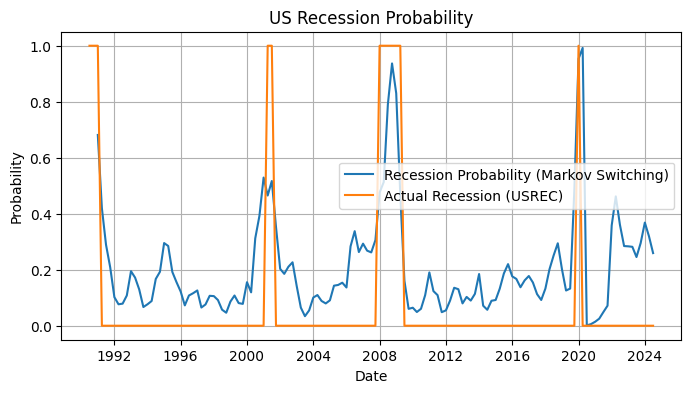

In [ ]:
model = sm.tsa.MarkovAutoregression(
    data['GrowthRate'],
    k_regimes = 2,
    order = 2,
    switching_ar = False,
    exog = data[['Unemployment', 'Inflation', 'InterestRate']])
results = model.fit(method = 'lbfgs', maxiter=1000)

print(results.summary())

recession_probs = results.smoothed_marginal_probabilities[0]
recession_probs = recession_probs.reindex(data.index, method='pad')

plt.figure(figsize = (8, 4))
plt.plot(data.index, recession_probs, label = 'Recession Probability (Markov Switching)')
plt.plot(data.index, data['USREC'], label = 'Actual Recession (USREC)')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('US Recession Probability')
plt.legend()
plt.grid()
plt.show()

## **Table 9. Manual Threshold Auto-Regressive (TAR / SETAR) model with Monthly inflation and unemployment preprocessing, lagged threshold variable (TAR standard practice), Grid-search to estimate optimal threshold, Regime construction, Separate AR models for each regime, Robust standard errors, and Summary of regime sizes.**

In [19]:
start_date = '1990-01-01'
end_date = '2025-01-01'

USREC = DataReader('USREC', 'fred', start_date, end_date)
inflation_data = DataReader('CPIAUCSL', 'fred', start_date, end_date)
unemployment = DataReader('UNRATE', 'fred', start_date, end_date)

# Monthly inflation (YoY log difference)
inflation_data = inflation_data.resample('MS').last()
inflation_data['Inflation'] = np.log(inflation_data['CPIAUCSL']).diff(periods=12) * 100

# Monthly unemployment rate
unemployment = unemployment.resample('MS').last()
USREC = USREC.resample('MS').last()

data = pd.merge(inflation_data[['Inflation']], unemployment, left_index=True, right_index=True)
data.rename(columns={'UNRATE': 'UnemploymentRate'}, inplace=True)
data.dropna(inplace=True)

# lagged threshold variable (avoids simultaneity)
data['Unemp_lag1'] = data['UnemploymentRate'].shift(1)

# AR(2) dynamic structure for inflation
data['Inflation_lag1'] = data['Inflation'].shift(1)
data['Inflation_lag2'] = data['Inflation'].shift(2)

data.dropna(inplace=True)

# Threshold estimation
def estimate_tar_model(threshold, data):
    """Estimate TAR model for given threshold and return total SSR"""
    regime_mask = data['Unemp_lag1'] > threshold
    regime_0 = data[~regime_mask]
    regime_1 = data[regime_mask]

    # minimum observations requirement # At least 10% of total observations
    min_obs = max(10, 0.1 * len(data))
    if len(regime_0) < min_obs or len(regime_1) < min_obs:
        return np.inf

    # Estimate models with robust SEs
    try:
        X0 = sm.add_constant(regime_0[['Inflation_lag1', 'Inflation_lag2']])
        model_0 = sm.OLS(regime_0['Inflation'], X0).fit(cov_type='HC3')

        X1 = sm.add_constant(regime_1[['Inflation_lag1', 'Inflation_lag2']])
        model_1 = sm.OLS(regime_1['Inflation'], X1).fit(cov_type='HC3')

        return model_0.ssr + model_1.ssr
    except:
        return np.inf

# Grid search from 10%–90% quantiles
threshold_candidates = np.quantile(data['Unemp_lag1'], np.linspace(0.1, 0.9, 50))
best_threshold = None
best_ssr = np.inf

print("Searching for optimal threshold...")
for threshold in threshold_candidates:
    ssr = estimate_tar_model(threshold, data)
    if ssr < best_ssr:
        best_ssr = ssr
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.2f}%")

# estimation with optimal threshold
data['regime'] = (data['Unemp_lag1'] > best_threshold).astype(int)
regime_0 = data[data['regime'] == 0]
regime_1 = data[data['regime'] == 1]

print(f"\nRegime 0 (Unemployment ≤ {best_threshold:.2f}%): {len(regime_0)} observations")
print(f"Regime 1 (Unemployment > {best_threshold:.2f}%): {len(regime_1)} observations")

# Separate OLS for each regime with heteroskedasticity-robust SEs (HC3)
X0 = sm.add_constant(regime_0[['Inflation_lag1', 'Inflation_lag2']])
model_0 = sm.OLS(regime_0['Inflation'], X0).fit(cov_type='HC3')

X1 = sm.add_constant(regime_1[['Inflation_lag1', 'Inflation_lag2']])
model_1 = sm.OLS(regime_1['Inflation'], X1).fit(cov_type='HC3')

print("\n" + "="*50)
print("REGIME 0 RESULTS (Low Unemployment)")
print("="*50)
print(model_0.summary())

print("\n" + "="*50)
print("REGIME 1 RESULTS (High Unemployment)")
print("="*50)
print(model_1.summary())

Searching for optimal threshold...
Optimal threshold: 5.40%

Regime 0 (Unemployment ≤ 5.40%): 213 observations
Regime 1 (Unemployment > 5.40%): 194 observations

REGIME 0 RESULTS (Low Unemployment)
                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1753.
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          9.56e-132
Time:                        17:39:38   Log-Likelihood:                -79.578
No. Observations:                 213   AIC:                             165.2
Df Residuals:                     210   BIC:                             175.2
Df Model:                           2                                         
Covariance Type:                  HC3                                         
            

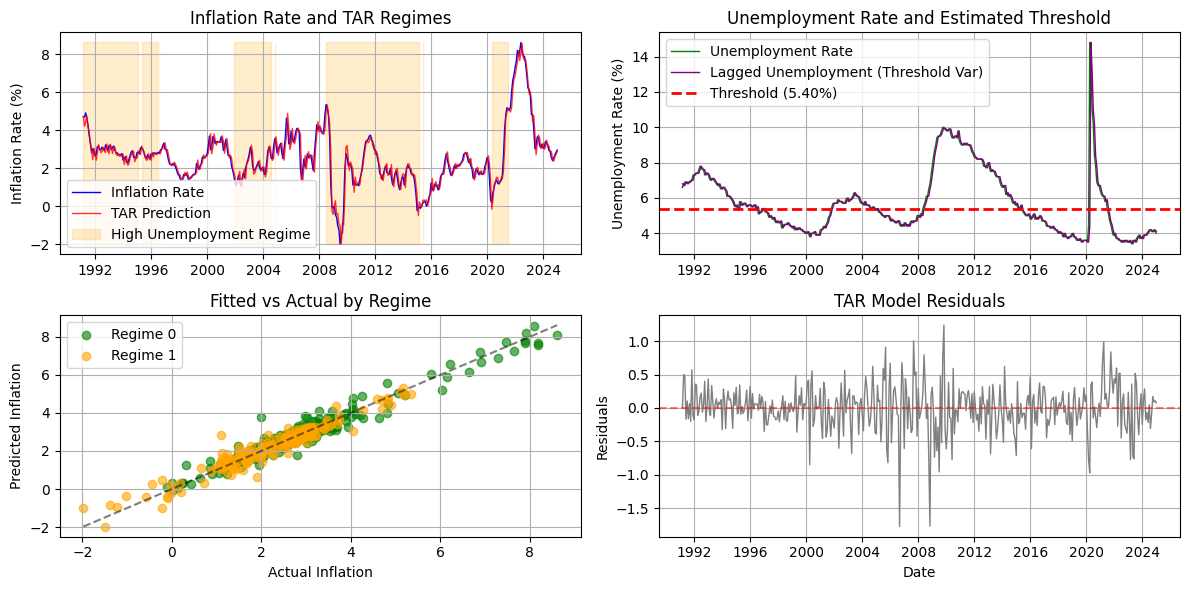


MODEL DIAGNOSTICS
Total R²: 0.947
Regime 0 R²: 0.954
Regime 1 R²: 0.926
Threshold variable: Lagged Unemployment Rate
Optimal threshold: 5.40%


In [23]:
data['predicted'] = np.nan
data.loc[data['regime'] == 0, 'predicted'] = model_0.predict(X0)
data.loc[data['regime'] == 1, 'predicted'] = model_1.predict(X1)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Inflation and regimes
ax = axes[0, 0]
ax.plot(data.index, data['Inflation'], label='Inflation Rate', color='blue', linewidth=1)
ax.plot(data.index, data['predicted'], label='TAR Prediction', color='red', linewidth=1, alpha=0.8)
ax.fill_between(data.index, data['Inflation'].min(), data['Inflation'].max(),
                where=data['regime'] == 1, alpha=0.2, color='orange', label='High Unemployment Regime')
ax.set_ylabel('Inflation Rate (%)')
ax.set_title('Inflation Rate and TAR Regimes')
ax.legend()
ax.grid()

# Unemployment rate and threshold
ax = axes[0, 1]
ax.plot(data.index, data['UnemploymentRate'], label='Unemployment Rate', color='green', linewidth=1)
ax.plot(data.index, data['Unemp_lag1'], label='Lagged Unemployment (Threshold Var)', color='purple', linewidth=1)
ax.axhline(y=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({best_threshold:.2f}%)')
ax.set_ylabel('Unemployment Rate (%)')
ax.set_title('Unemployment Rate and Estimated Threshold')
ax.legend()
ax.grid()

# Fitted vs actual by regime
ax = axes[1, 0]
colors = ['green', 'orange']
for regime, color in zip([0, 1], colors):
    regime_data = data[data['regime'] == regime]
    ax.scatter(regime_data['Inflation'], regime_data['predicted'],
               alpha=0.6, color=color, label=f'Regime {regime}')
ax.plot([data['Inflation'].min(), data['Inflation'].max()],
        [data['Inflation'].min(), data['Inflation'].max()], 'k--', alpha=0.5)
ax.set_xlabel('Actual Inflation')
ax.set_ylabel('Predicted Inflation')
ax.set_title('Fitted vs Actual by Regime')
ax.legend()
ax.grid()

# Residuals
ax = axes[1, 1]
residuals = data['Inflation'] - data['predicted']
ax.plot(data.index, residuals, color='gray', linewidth=1)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('TAR Model Residuals')
ax.grid()

plt.tight_layout()
plt.show()

# Model diagnostics
print("\nMODEL DIAGNOSTICS")
print(f"Total R²: {1 - (model_0.ssr + model_1.ssr)/((data['Inflation'] - data['Inflation'].mean()).var() * (len(data)-1)):.3f}")
print(f"Regime 0 R²: {model_0.rsquared:.3f}")
print(f"Regime 1 R²: {model_1.rsquared:.3f}")
print(f"Threshold variable: Lagged Unemployment Rate")
print(f"Optimal threshold: {best_threshold:.2f}%")

## **Table 10. Exploratory analysis**

In [ ]:
start_date = '1990-01-01'
end_date = '2023-01-01'
gdp_data = DataReader('GDPC1', 'fred', start_date, end_date)
interest_rate = DataReader('GS10', 'fred', start_date, end_date)

gdp_data = gdp_data.resample('QS').last()
gdp_data['GrowthRate'] = gdp_data['GDPC1'].pct_change() * 100
gdp_data.dropna(inplace=True)

interest_rate = interest_rate.resample('QS').last()
interest_rate.dropna(inplace=True)

data = pd.merge(gdp_data[['GrowthRate']], interest_rate, left_index=True, right_index=True)
data.rename(columns={'GS10': 'InterestRate'}, inplace=True)

data['LaggedGDPGrowth'] = data['GrowthRate'].shift(1)
data['LaggedInterestRate'] = data['InterestRate'].shift(1)
data.dropna(inplace=True)

dependent_var = data['GrowthRate']
transition_var1 = data['LaggedGDPGrowth']
transition_var2 = data['LaggedInterestRate']

def linearity_test(y, x):
    x_squared = x**2
    x_cubed = x**3
    x_augmented = pd.concat([x, x_squared, x_cubed], axis=1)
    x_augmented.columns = ['x', 'x_squared', 'x_cubed']

    x_augmented = sm.add_constant(x_augmented)
    model = sm.OLS(y, x_augmented).fit()

    test_result = model.f_test("x_squared = 0, x_cubed = 0")
    return test_result

print("Linearity Test for Lagged GDP Growth Rate:")
test_result1 = linearity_test(dependent_var, transition_var1)
print(test_result1)
print("\n")
print("Linearity Test for Lagged Interest Rate:")
test_result2 = linearity_test(dependent_var, transition_var2)
print(test_result2)
correlation1 = dependent_var.corr(transition_var1)
correlation2 = dependent_var.corr(transition_var2)
print("\nCorrelation between GDP Growth Rate and Lagged GDP Growth Rate:", correlation1)
print("Correlation between GDP Growth Rate and Lagged Interest Rate:", correlation2)

Linearity Test for Lagged GDP Growth Rate:
<F test: F=44.025305320603906, p=2.9867790440303986e-15, df_denom=127, df_num=2>


Linearity Test for Lagged Interest Rate:
<F test: F=2.321110779205665, p=0.10231537680068598, df_denom=127, df_num=2>

Correlation between GDP Growth Rate and Lagged GDP Growth Rate: -0.13988109060949644
Correlation between GDP Growth Rate and Lagged Interest Rate: 0.038490417391878175


## **Table 11. STAR model implementation using custom code**

Estimated parameters: [  -8.70213776    0.67659318 -621.05255812  -77.01202124  623.00033786
   76.85943096]


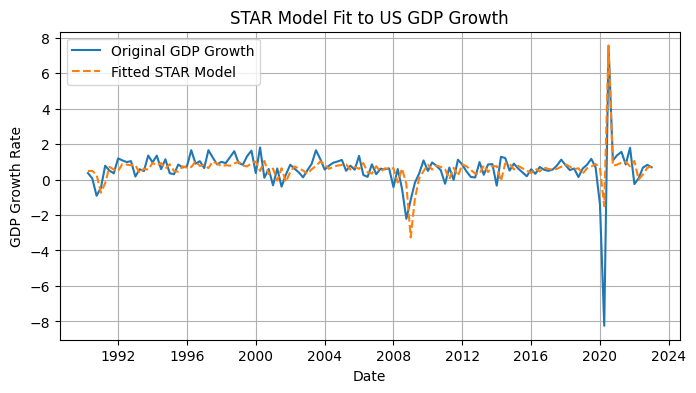

In [ ]:
start_date = '1990-01-01'
end_date = '2025-01-01'
gdp_data = DataReader('GDPC1', 'fred', start_date, end_date)

gdp_data = gdp_data.resample('QS').last()
gdp_data['GrowthRate'] = np.log(gdp_data['GDPC1']/gdp_data['GDPC1'].shift(1)) * 100
gdp_data.dropna(inplace=True)

y = gdp_data['GrowthRate'].values
lagged_y = np.roll(y, 1)
lagged_y[0] = lagged_y[1]

def logistic_transition(c, gamma, z):
    return 1 / (1 + np.exp(-gamma * (z - c)))

def star_model(params, y, lagged_y, z):
    c, gamma, phi0, phi1, theta0, theta1 = params
    G = logistic_transition(c, gamma, z)
    y_hat = (phi0 + phi1 * lagged_y) + G * (theta0 + theta1 * lagged_y)
    return y_hat

# Fit the model using nonlinear least squares
initial_params = [np.mean(lagged_y), 0.1, 1, 0.5, 1, 0.5]
res = minimize(lambda params: np.sum((star_model(params, y, lagged_y, lagged_y) - y) ** 2), initial_params)

print("Estimated parameters:", res.x)

y_pred = star_model(res.x, y, lagged_y, lagged_y)

plt.figure(figsize=(8, 4))
plt.plot(gdp_data.index, y, label='Original GDP Growth')
plt.plot(gdp_data.index, y_pred, '--', label='Fitted STAR Model')
plt.xlabel('Date')
plt.ylabel('GDP Growth Rate')
plt.title('STAR Model Fit to US GDP Growth')
plt.legend()
plt.grid()
plt.show()

In [ ]:
stationarity_test(gdp_data['GrowthRate'], 'GDP Growth Rate')


GDP Growth Rate Stationarity Test:
ADF Statistic: -13.00644510035205
p-value: 2.621747534831786e-24
Stationary


Estimated parameters: [-2.99182640e+00  1.19666973e-01 -3.24139537e+02 -1.94925584e+01
  5.50867153e+02  7.26500263e+00]


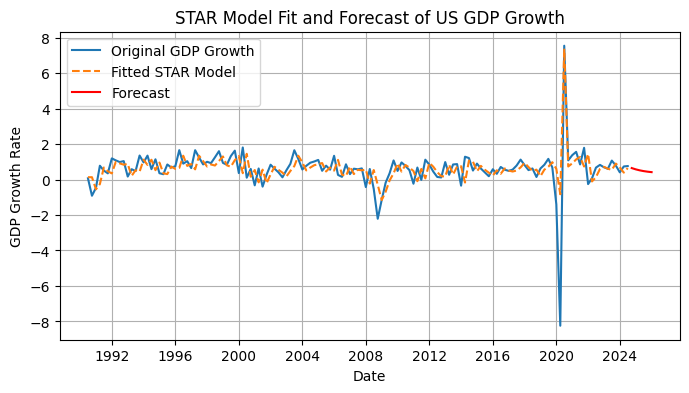

In [ ]:
start_date = '1990-01-01'
end_date = '2025-01-01'
gdp_data = DataReader('GDPC1', 'fred', start_date, end_date)

gdp_data = gdp_data.resample('QS').last()
gdp_data['GrowthRate'] = np.log(gdp_data['GDPC1']/gdp_data['GDPC1'].shift(1)) * 100
gdp_data.dropna(inplace=True)

y = gdp_data['GrowthRate'].values
lagged_y = np.roll(y, 1)
lagged_y[0] = lagged_y[1]

def logistic_transition(c, gamma, z):
    return 1 / (1 + np.exp(-gamma * (z - c)))

def star_model(params, y, lagged_y, z):
    c, gamma, phi0, phi1, theta0, theta1 = params
    G = logistic_transition(c, gamma, z)
    y_hat = (phi0 + phi1 * lagged_y) + G * (theta0 + theta1 * lagged_y)
    return y_hat

initial_params = [np.mean(lagged_y), 0.1, 1, 0.5, 1, 0.5]
res = minimize(lambda params: np.sum((star_model(params, y, lagged_y, lagged_y) - y) ** 2), initial_params)

print("Estimated parameters:", res.x)

forecast_periods = 6
lagged_y_forecast = np.concatenate([lagged_y[-1:], np.zeros(forecast_periods)])

y_forecast = []
for i in range(forecast_periods):
    lagged_y_forecast[i+1] = star_model(res.x, y, lagged_y_forecast[i:i+1], lagged_y_forecast[i:i+1])[0]
    y_forecast.append(lagged_y_forecast[i+1])


y_pred = star_model(res.x, y, lagged_y, lagged_y)

plt.figure(figsize = (8, 4))
plt.plot(gdp_data.index, y, label='Original GDP Growth')
plt.plot(gdp_data.index, y_pred, '--', label='Fitted STAR Model')

forecast_index = pd.date_range(gdp_data.index[-1], periods=forecast_periods+1, freq = 'QS')[1:]
plt.plot(forecast_index, y_forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('GDP Growth Rate')
plt.title('STAR Model Fit and Forecast of US GDP Growth')
plt.legend()
plt.grid()
plt.show()

Estimated parameters: [-1.58798881e+00  7.94947655e+01  4.04959851e+00  5.04635818e-01
 -4.10476239e+00 -3.11865215e-01  3.22885516e-02 -3.84851673e-02]


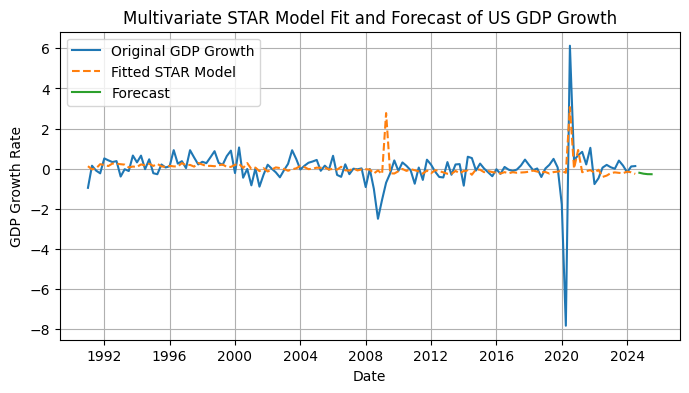

In [ ]:
start_date = '1990-01-01'
end_date = '2025-01-01'
gdp_data = DataReader('GDPC1', 'fred', start_date, end_date)
interest_rate_data = DataReader('GS10', 'fred', start_date, end_date)
inflation_data = DataReader('CPIAUCSL', 'fred', start_date, end_date)

# Resample to quarterly frequency
gdp_data = gdp_data.resample('QS').last()
interest_rate_data = interest_rate_data.resample('QS').last()
inflation_data = inflation_data.resample('QS').last()

# Calculate GDP growth rate
gdp_data['GrowthRate'] = np.log(gdp_data['GDPC1'] / gdp_data['GDPC1'].shift(1)) * 100

data = pd.merge(gdp_data[['GrowthRate']], interest_rate_data, left_index=True, right_index=True)
data = pd.merge(data, inflation_data, left_index=True, right_index=True)
data.rename(columns={'GS10': 'InterestRate', 'CPIAUCSL': 'Inflation'}, inplace=True)

data['LaggedGDPGrowth'] = data['GrowthRate'].shift(1)
data['LaggedInterestRate'] = data['InterestRate'].shift(1)
data['LaggedInflation'] = data['Inflation'].shift(1)
data.dropna(inplace=True)

scaler = StandardScaler()
cols_to_scale = ['GrowthRate', 'InterestRate', 'Inflation', 'LaggedGDPGrowth', 'LaggedInterestRate', 'LaggedInflation']
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

def logistic_transition(c, gamma, z):
    return 1 / (1 + np.exp(-gamma * (z - c)))

def multivariate_star_model(params, y, lagged_y, z, exog):
    c, gamma, phi0, phi1, theta0, theta1, beta1, beta2 = params
    G = logistic_transition(c, gamma, z)

    if exog.ndim == 1:
        exog = exog.reshape(1, -1)

    y_hat = (phi0 + phi1 * lagged_y + exog[:, 0] * beta1 + exog[:, 1] * beta2) + \
            G * (theta0 + theta1 * lagged_y + exog[:, 0] * beta1 + exog[:, 1] * beta2)
    return y_hat

y = data['GrowthRate'].values
lagged_y = data['LaggedGDPGrowth'].values
transition_variable = data['LaggedGDPGrowth'].values # Using Lagged GDP Growth as transition variable
exog_vars = data[['LaggedInterestRate', 'LaggedInflation']].values

initial_params = [np.mean(lagged_y), 0.1, 1, 0.5, 1, 0.5, 0, 0]  # Initial parameters

res = minimize(lambda params: np.sum((multivariate_star_model(params, y[1:-1], lagged_y[1:-1], transition_variable[1:-1], exog_vars[:-2]) - y[2:]) ** 2),
               initial_params)

print("Estimated parameters:", res.x)

num_bootstraps = 1000
forecast_periods = 4
forecast_samples = np.zeros((num_bootstraps, forecast_periods))

for i in range(num_bootstraps):
    residuals = y[2:] - multivariate_star_model(res.x, y[1:-1], lagged_y[1:-1], transition_variable[1:-1], exog_vars[:-2])
    resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    y_bootstrapped = multivariate_star_model(res.x, y[1:-1], lagged_y[1:-1], transition_variable[1:-1], exog_vars[:-2]) + resampled_residuals
    lagged_y_forecast = np.concatenate([lagged_y[-1:], np.zeros(forecast_periods)])
    exog_forecast = data[['LaggedInterestRate', 'LaggedInflation']].values[-forecast_periods - 1:-1]
    y_forecast_bootstrap = []
    for j in range(forecast_periods):
        lagged_y_forecast[j + 1] = multivariate_star_model(res.x, y_bootstrapped, lagged_y_forecast[j:j + 1], lagged_y_forecast[j:j + 1], exog_forecast[j])[0]
        y_forecast_bootstrap.append(lagged_y_forecast[j + 1])
    forecast_samples[i, :] = y_forecast_bootstrap

y_pred = multivariate_star_model(res.x, y[1:-1], lagged_y[1:-1], transition_variable[1:-1], exog_vars[:-2])
lagged_y_forecast = np.concatenate([lagged_y[-1:], np.zeros(forecast_periods)])
exog_forecast = data[['LaggedInterestRate', 'LaggedInflation']].values[-forecast_periods - 1:]
y_forecast = []
for i in range(forecast_periods):
    lagged_y_forecast[i + 1] = multivariate_star_model(res.x, y, lagged_y_forecast[i:i + 1], lagged_y_forecast[i:i + 1], exog_forecast[i])[0]
    y_forecast.append(lagged_y_forecast[i + 1])

plt.figure(figsize=(8, 4))
plt.plot(data.index[2:], y[2:], label='Original GDP Growth')
plt.plot(data.index[2:], y_pred, '--', label='Fitted STAR Model')

forecast_index = pd.date_range(data.index[-1], periods=forecast_periods + 1, freq='QS')[1:]
plt.plot(forecast_index, y_forecast, label='Forecast')

plt.xlabel('Date')
plt.ylabel('GDP Growth Rate')
plt.title('Multivariate STAR Model Fit and Forecast of US GDP Growth')
plt.legend()
plt.grid()
plt.show()